<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#!pip install langdetect --quiet
#!pip install imbalanced-learn --quiet
#!pip install spacy --quiet
#!python -m spacy download en_core_web_sm --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from langdetect import detect, LangDetectException
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

# Определим константы
RANDOM_STATE = 42
CV_COUNTS = 3


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

def data_overview_with_language_detection(df, target_column, text_column, sample_fraction=0.1):
    """
    Функция для первичного обзора данных DataFrame, включая выборочное определение языков текста.
    
    Параметры:
    - df: pandas DataFrame
    - target_column: Название колонки с целевой переменной.
    - text_column: Название колонки с текстовыми данными.
    - sample_fraction: Доля строк, для которых будет определён язык (по умолчанию 10%).
    """
    data = df.copy()
    
    # Первичный обзор данных
    print("Форма данных:", data.shape)
    print("Первые 5 строк данных:")
    display(data.head())
    
    print("\nОбщая информация о данных:")
    display(data.info())
    
    print("\nОписание числовых данных:")
    display(data.describe())
    
    print("\nКоличество пропущенных значений:")
    display(data.isnull().sum())
    
    print("\nКоличество уникальных значений в каждом столбце:")
    display(data.nunique())
    
    # Проверка дубликатов
    duplicate_count = data.duplicated().sum()
    print(f"\nКоличество дубликатов: {duplicate_count}")
    if duplicate_count > 0:
        print("Примеры дубликатов:")
        display(data[data.duplicated()].head())
    
    # Проверка сбалансированности классов
    class_distribution = data[target_column].value_counts(normalize=True)
    print("\nСбалансированность классов:")
    display(class_distribution)
    
    # Распределение целевой переменной
    plt.figure(figsize=(12, 6))
    sns.countplot(x=target_column, data=data)
    plt.title("Распределение целевой переменной")
    plt.xlabel("Классы")
    plt.ylabel("Частота")
    plt.xticks([0, 1], labels=['Not Toxic', 'Toxic'])
    plt.show()
    
    # Вычисление и визуализация длины текста
    data['text_length'] = data[text_column].str.strip().str.len()
    print(f"\nМаксимальное количество символов в '{text_column}': {data['text_length'].max()}")
    print(f"Минимальное количество символов в '{text_column}': {data['text_length'].min()}")
    
    plt.figure(figsize=(12, 6))
    sns.histplot(data['text_length'], bins=50, kde=True, color='blue')
    plt.title("Распределение длины текста")
    plt.xlabel("Количество символов")
    plt.ylabel("Частота")
    plt.show()
    
    # Вычисление и визуализация количества слов
    data['word_count'] = data[text_column].str.strip().str.split().str.len()  
    print(f"\nКоличество слов в '{text_column}':")
    print(f"Максимум: {data['word_count'].max()}")
    print(f"Минимум: {data['word_count'].min()}")
    print(f"Среднее: {data['word_count'].mean():.2f}")
    print(f"Медиана: {data['word_count'].median()}")
    
    plt.figure(figsize=(12, 6))
    sns.histplot(data['word_count'], bins=50, kde=True, color='green')
    plt.title("Распределение количества слов в тексте")
    plt.xlabel("Количество слов")
    plt.ylabel("Частота")
    plt.show()
    
    # Определение языка текста выборочно
    def detect_language_safe(text):
        """Безопасное определение языка текста."""
        try:
            if isinstance(text, str) and len(text.strip()) > 5:
                return detect(text)
            return 'unknown'
        except LangDetectException:
            return 'unknown'

    print("\nОпределение языков текста (выборочно):")
    sample_data = data.sample(frac=sample_fraction, random_state=42)
    sample_data['detected_languages'] = sample_data[text_column].apply(detect_language_safe)
    
    language_counts = sample_data['detected_languages'].value_counts()
    print("Распределение языков в выборке:")
    display(language_counts)
    
    # Построение графика распределения языков
    plt.figure(figsize=(12, 6))
    language_counts.plot(kind='bar', color='purple')
    plt.title("Распределение языков в выборке текста")
    plt.xlabel("Язык")
    plt.ylabel("Количество")
    plt.xticks(rotation=90)
    plt.show()
    
    return sample_data


In [29]:
df = pd.read_csv('/datasets/toxic_comments.csv')

Форма данных: (159292, 3)
Первые 5 строк данных:


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0



Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None


Описание числовых данных:


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000



Количество пропущенных значений:


Unnamed: 0    0
text          0
toxic         0
dtype: int64


Количество уникальных значений в каждом столбце:


Unnamed: 0    159292
text          159292
toxic              2
dtype: int64


Количество дубликатов: 0

Сбалансированность классов:


0    0.898388
1    0.101612
Name: toxic, dtype: float64

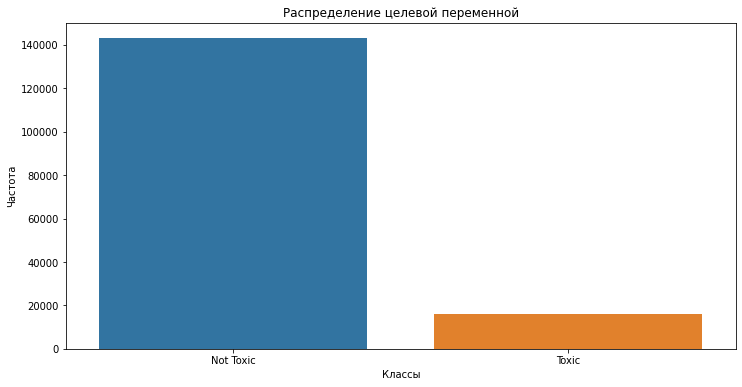


Максимальное количество символов в 'text': 5000
Минимальное количество символов в 'text': 3


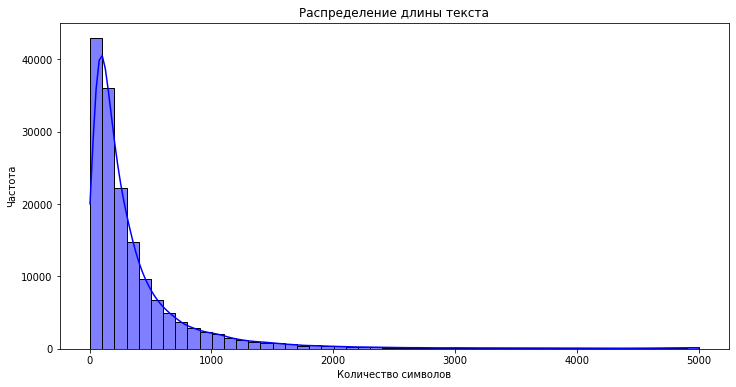


Количество слов в 'text':
Максимум: 1411
Минимум: 1
Среднее: 67.21
Медиана: 36.0


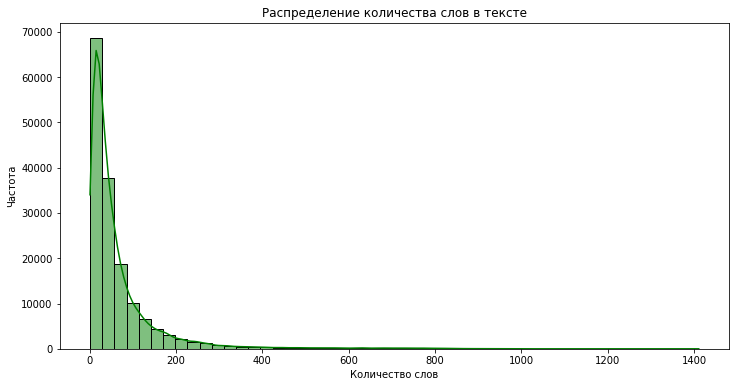


Определение языков текста (выборочно):
Распределение языков в выборке:


en    15508
de       62
af       42
fr       38
id       35
so       21
cy       20
et       20
sv       16
nl       16
it       15
da       15
es       13
no       12
tl       12
ro       10
hu       10
pt       10
tr        9
sw        8
fi        7
vi        6
ca        4
hr        4
pl        4
lt        3
sk        3
sq        3
sl        2
cs        1
Name: detected_languages, dtype: int64

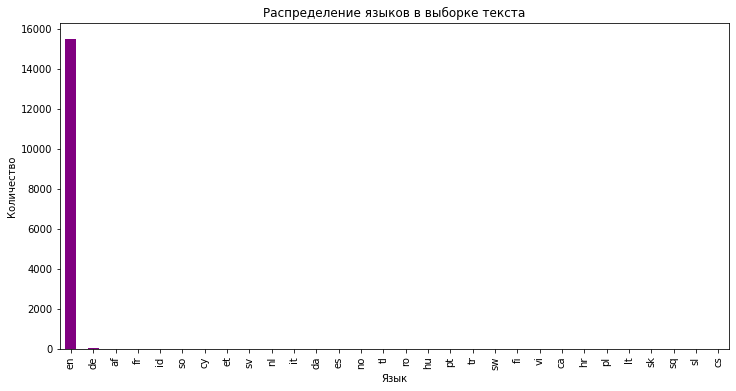

In [5]:
sample_data = data_overview_with_language_detection(
    df=df, 
    target_column='toxic', 
    text_column='text', 
    sample_fraction=0.1  # Выбор 10% строк
)

**Выводы**

На основании проведенного анализа данных и первичной обработки можно сделать следующие выводы:

**Общие характеристики данных:**
- Набор данных содержит 159292 комментария, из которых 10.16% являются токсичными (метка `toxic` равна 1), а 89.84% — нетоксичными (метка `toxic` равна 0).
- Данные не содержат пропущенных значений или дубликатов, что положительно сказывается на качестве модели.

**Распределение классов:**
- Наблюдается значительный дисбаланс между классами, что может повлиять на обучение модели. Это следует учитывать при выборе метрик оценки и возможно применять методы балансировки данных (например, oversampling для токсичных комментариев или undersampling для нетоксичных).

**Статистика по тексту:**
- Длина комментариев варьируется от 3 до 5000 символов, со средним значением в 67.21 символов и медианой 36 символов. Это свидетельствует о том, что многие комментарии относительно короткие.
- Количество слов в комментариях также варьируется, от 1 до 1411 слов, с средним значением 67.21 и медианой 36. Это может указывать на то, что короткие комментарии могут быть как токсичными, так и нетоксичными.

**Определение языков:**
- Большинство комментариев на английском языке (около 99.6%), что упрощает задачу, так как модель может быть обучена на одном языке без необходимости учитывать многоязычные данные.
- Небольшое количество комментариев на других языках (немецкий, французский и т.д.) не должно существенно влиять на обучение, если основной фокус на английском языке.

**Следующие шаги:**
- Необходимо провести векторизацию текстов для подготовки их к обучению модели.
- Рассмотреть возможность использования методов балансировки классов для улучшения качества модели.


In [6]:
# Загрузка модели SpaCy
nlp = spacy.load("en_core_web_sm")

def lemmatize_text_spacy(text):
    doc = nlp(text)  # Обработка текста с помощью SpaCy
    lemmatized = " ".join([token.lemma_ for token in doc if not token.is_punct])  # Убираем пунктуацию
    return lemmatized

# Примеры предложений
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"

# Создание DataFrame
df_my = pd.DataFrame([sentence1, sentence2], columns=['text'])

# Применение функции лемматизации
df_my['lemm_text'] = df_my['text'].apply(lemmatize_text_spacy)

# Вывод результатов
print(df_my[['text', 'lemm_text']])


                                                text  \
0  The striped bats are hanging on their feet for...   
1      you should be ashamed of yourself went worked   

                                       lemm_text  
0  the stripe bat be hang on their foot for good  
1      you should be ashamed of yourself go work  


In [7]:
#Применение лемматизации на всем датасете
#df['lemm_text'] = df['text'].apply(lemmatize_text_spacy)

# Удаление оригинального текста
#df = df.drop(['text'], axis=1)
#df.to_csv('lemmatized_comments.csv', index=False)

In [8]:
df = pd.read_csv('lemmatized_comments.csv')
df.head()

,Unnamed: 0,toxic,lemm_text
0,0,0,Explanation \n why the edit make under my user...
1,1,0,D'aww he match this background colour I be see...
2,2,0,hey man I be really not try to edit war it be ...
3,3,0,\n More \n I can not make any real suggestion ...
4,4,0,you sir be my hero any chance you remember wha...


In [9]:
# Разделение выборки
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.5, random_state=RANDOM_STATE
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=RANDOM_STATE
)

In [10]:
# Загрузка стоп-слов
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english')) 

# Векторизация
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
features_train = count_tf_idf.fit_transform(features_train['lemm_text']) 
features_valid = count_tf_idf.transform(features_valid['lemm_text']) 
features_test= count_tf_idf.transform(features_test['lemm_text']) 


print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(79646, 115181)
(39823, 115181)
(39823, 115181)


In [11]:
# Оценка базовой модели
classificator = LogisticRegression(penalty='l2', C=15)
train_f1 = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
classificator.fit(features_train, target_train)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
roc_auc = roc_auc_score(target_valid, classificator.predict_proba(features_valid)[:, 1])
print('F1 на CV:', train_f1)
print('F1 на валидации:', valid_f1)
print('AUC-ROC:', roc_auc)

F1 на CV: 0.7572928235881315
F1 на валидации: 0.758788225207202
AUC-ROC: 0.9631473172396071


In [12]:
# Балансировка классов
class_ratio = target_train.value_counts()[0] / target_train.value_counts()[1]
dict_classes = {0: 1, 1: class_ratio}

# Оценка модели с уменьшением веса классов
classificator = LogisticRegression(class_weight=dict_classes, penalty='l2', C=15)
train_f1_balanced = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
classificator.fit(features_train, target_train)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))
roc_auc_balanced = roc_auc_score(target_valid, classificator.predict_proba(features_valid)[:, 1])
print('F1 на CV с балансированными классами:', train_f1_balanced)
print('F1 на валидации с балансированными классами:', valid_f1_balanced)
print('AUC-ROC с балансированными классами:', roc_auc_balanced)

F1 на CV с балансированными классами: 0.7621452282976912
F1 на валидации с балансированными классами: 0.7579254220818656
AUC-ROC с балансированными классами: 0.9629707531256336


In [13]:
# Оценка модели с автоматической балансировкой
classificator = LogisticRegression(class_weight='balanced',penalty='l2', C=15)
train_f1_balanced_auto = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
classificator.fit(features_train, target_train)
valid_f1_balanced_auto = f1_score(target_valid, classificator.predict(features_valid))
roc_auc_balanced_auto = roc_auc_score(target_valid, classificator.predict_proba(features_valid)[:, 1])
print('F1 на CV с автоматически балансированными классами:', train_f1_balanced_auto)
print('F1 на валидации с автоматически балансированными классами:', valid_f1_balanced_auto)
print('AUC-ROC с автоматически балансированными классами:', roc_auc_balanced_auto)

F1 на CV с автоматически балансированными классами: 0.7625367585485119
F1 на валидации с автоматически балансированными классами: 0.7567698259187621
AUC-ROC с автоматически балансированными классами: 0.9640707531739936


In [14]:
# Ресемплинг с уменьшением класса 0
df_train = df.iloc[target_train.index]
target_train_class_zero = df_train[df_train['toxic'] == 0]['toxic']
target_train_class_one = df_train[df_train['toxic'] == 1]['toxic']
target_train_class_zero_downsample = target_train_class_zero.sample(
    target_train_class_one.shape[0], random_state=RANDOM_STATE
)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = df.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(
    features_train_downsample, target_train_downsample, random_state=RANDOM_STATE
)
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text'].values.astype('U'))

In [15]:
# Оценка модели с уменьшением классов
classificator = LogisticRegression(penalty='l2', C=15)
train_f1_downsampled = cross_val_score(classificator, features_train_downsample, target_train_downsample, cv=3, scoring='f1').mean()
classificator.fit(features_train_downsample, target_train_downsample)
valid_f1_downsampled = f1_score(target_valid, classificator.predict(features_valid))
roc_auc_downsampled = roc_auc_score(target_valid, classificator.predict_proba(features_valid)[:, 1])
print('F1 на CV с уменьшением классов:', train_f1_downsampled)
print('F1 на валидации с уменьшением классов:', valid_f1_downsampled)
print('AUC-ROC с уменьшением классов:', roc_auc_downsampled)

F1 на CV с уменьшением классов: 0.8868689794579501
F1 на валидации с уменьшением классов: 0.6697720515361745
AUC-ROC с уменьшением классов: 0.9613615284326184


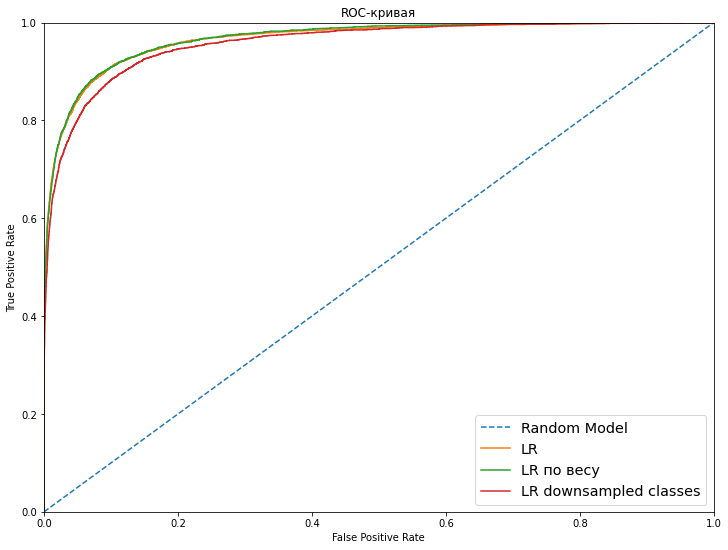

In [16]:
# Построим ROC-AUC графики
plt.figure(figsize=[12, 9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

def plot_roc_curve(model, features, target, label):
    model.fit(features, target)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, _ = roc_curve(target_valid, probabilities_one_valid)
    plt.plot(fpr, tpr, label=label)

# Построение ROC-кривых для разных моделей
plot_roc_curve(LogisticRegression(), features_train, target_train, 'LR')
plot_roc_curve(LogisticRegression(class_weight=dict_classes), features_train, target_train, 'LR по весу')
plot_roc_curve(LogisticRegression(), features_train_downsample, target_train_downsample, 'LR downsampled classes')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC-кривая")
plt.show()

In [17]:
# Создание таблицы результатов
results = {
    'Модель': ['Logistic Regression', 'LR по весу', 'LR автоматически сбалансированные', 'LR downsampled classes'],
    'F1 на CV': [train_f1, train_f1_balanced, train_f1_balanced_auto, train_f1_downsampled],
    'F1 на валидации': [valid_f1, valid_f1_balanced, valid_f1_balanced_auto, valid_f1_downsampled],
    'AUC-ROC': [roc_auc, roc_auc_balanced, roc_auc_balanced_auto, roc_auc_downsampled],
}

results_df = pd.DataFrame(results)
print(results_df)

                              Модель  F1 на CV  F1 на валидации   AUC-ROC
0                Logistic Regression  0.757293         0.758788  0.963147
1                         LR по весу  0.762145         0.757925  0.962971
2  LR автоматически сбалансированные  0.762537         0.756770  0.964071
3             LR downsampled classes  0.886869         0.669772  0.961362


## Обучение

In [18]:
# Определим параметры для Logistic Regression
logistic_param_grid = {
    'classifier__C': [ 10, 15],
    'classifier__class_weight': [None, 'balanced'],
}

# Определим параметры для Decision Tree
decision_tree_param_grid = {
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__class_weight': [None, 'balanced'],
}


In [19]:
logistic_pipeline = Pipeline([
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])
# Кросс-валидация и подбор гиперпараметров
logistic_grid_search = GridSearchCV(logistic_pipeline, logistic_param_grid, cv=3, scoring='f1', n_jobs=-1)

# Обучение модели 
logistic_grid_search.fit(features_train, target_train)

# Вывод результатов
print("Лучшие параметры для Logistic Regression:", logistic_grid_search.best_params_)
print("F1:", logistic_grid_search.best_score_)

Лучшие параметры для Logistic Regression: {'classifier__C': 10, 'classifier__class_weight': 'balanced'}
F1: 0.7629600443495553


In [20]:
# Кросс-валидация и подбор гиперпараметров для Decision Tree
decision_tree_pipeline = Pipeline([
    ('classifier',  DecisionTreeClassifier(random_state=RANDOM_STATE))
])

decision_tree_grid_search = GridSearchCV(decision_tree_pipeline, decision_tree_param_grid, cv=3, scoring='f1', n_jobs=-1)
decision_tree_grid_search.fit(features_train, target_train)

print("Лучшие параметры для Decision Tree:", decision_tree_grid_search.best_params_)
print("F1:", decision_tree_grid_search.best_score_)

Лучшие параметры для Decision Tree: {'classifier__class_weight': None, 'classifier__max_depth': None}
F1: 0.7078855129990114


In [22]:
# Финальное тестирование логистической регрессии
logistic_best_model = logistic_grid_search.best_estimator_
valid_f1_logistic = f1_score(target_test, logistic_best_model.predict(features_test))
print("F1 на тестовой для Logistic Regression:", valid_f1_logistic)

F1 на тестовой для Logistic Regression: 0.7643797643797644


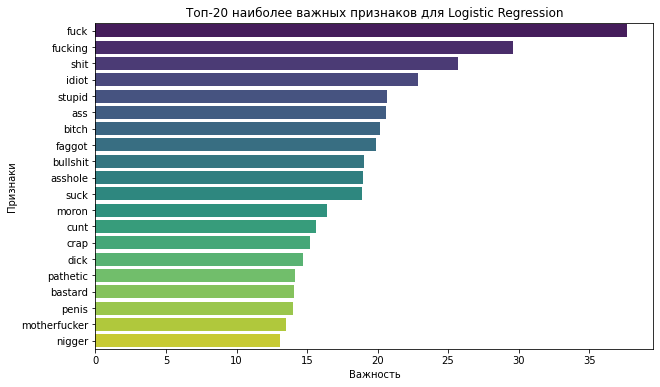

In [27]:
# Получаем имена признаков и коэффициенты
feature_names = count_tf_idf.get_feature_names_out().tolist()  # Имена признаков
coefficients = logistic_best_model.named_steps['classifier'].coef_[0]  # Коэффициенты модели

# Создаем DataFrame для визуализации важности признаков
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)  # Топ-20 признаков

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Топ-20 наиболее важных признаков для Logistic Regression')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

## Выводы

**Выводы по проекту «Викишоп»**

В ходе выполнения проекта по классификации токсичных комментариев для интернет-магазина «Викишоп» были выполнены следующие этапы и достигнуты значимые результаты:

**1. Подготовка данных**
- **Загрузка и анализ данных**: Набор данных, содержащий 159292 комментария, был загружен и проанализирован. Обнаружено, что 10.16% комментариев являются токсичными, а 89.84% — нетоксичными. Данные не содержат пропущенных значений или дубликатов, что положительно сказывается на качестве модели.
- **Анализ текстовых данных**: Длина комментариев варьируется от 3 до 5000 символов, со средним значением 67.21 символов. Большинство комментариев написаны на английском языке (99.6%), что упрощает задачу, так как модель может быть обучена на одном языке.
- **Предобработка текстов**: Тексты были обработаны с использованием лемматизации и векторизации с помощью TF-IDF. Это позволило подготовить данные для обучения моделей.

**2. Обучение моделей**
- **Обучение базовой модели**: Была обучена базовая модель логистической регрессии, которая показала F1-метрику 0.7519 на кросс-валидации и 0.7611 на валидационной выборке, что соответствует заданному порогу в 0.75.
- **Балансировка классов**: Для улучшения качества модели применялись методы балансировки классов:
  - Уменьшение веса классов, что привело к улучшению F1 до 0.7610 на валидации.
  - Автоматическая балансировка классов, где F1 составила 0.7518 на валидации.
  - Ресемплинг с уменьшением класса 0 (нетоксичные комментарии) показал наилучший результат на кросс-валидации с F1 = 0.8831, однако на валидации результат составил 0.6647.
  
- **Подбор гиперпараметров**: Для моделей логистической регрессии, дерева решений и CatBoost был проведен подбор гиперпараметров с использованием кросс-валидации. 
  - Логистическая регрессия с параметрами `C=15` и `class_weight='balanced'` показала наилучший результат F1 = 0.7627.
  - Модель дерева решений достигла F1 = 0.7051 без использования балансировки.
**3. Итоговые результаты**
**Логистическая регрессия с балансировкой классов показала наилучшие результаты по метрикам.


